In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 15)})

from tqdm.notebook import tqdm
tqdm().pandas()

# Pooled variance metric
def get_variance(df):
    variances = df.groupby(level=0).var()
    samplesizes = df.groupby(level=0).size()
    
    a = variances.loc[variances.index.repeat(samplesizes)].reset_index(drop=True)
    return a

def filter_submissions(df):
    filt = df.groupby(level=0).size() > 1
    return df[filt[df.index.get_level_values(level=0)].values]

# Classifier columns to study
cols = [('danceability', 'danceable'), ('mood_acoustic', 'acoustic'), ('mood_aggressive', 'aggressive'),
('mood_electronic', 'electronic'), ('mood_happy', 'happy'), ('mood_party', 'party'),
('mood_relaxed', 'relaxed'), ('mood_sad', 'sad')]



beatles = pd.read_hdf(Path.cwd() / 'datasets' / 'beatles.h5')
acousticbrainz = pd.read_hdf(Path.cwd() / 'datasets' / 'acousticbrainzV3.h5')

C:\Users\Chris\Miniconda3\envs\thesis\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
toplot = pd.DataFrame()


beatles_all = beatles.progress_apply(filter_submissions)
beatles_all_variance = beatles_all[cols].progress_apply(get_variance)
beatles_all_variance['Data source'] = "Beatles songs"
toplot = toplot.append(beatles_all_variance)

acousticbrainz_all = acousticbrainz.progress_apply(filter_submissions)
acousticbrainz_all_variance = acousticbrainz_all[cols].progress_apply(get_variance)
acousticbrainz_all_variance['Data source'] = "Full dataset"
toplot = toplot.append(acousticbrainz_all_variance)

Full dataset     7528144
Beatles songs     170320
Name: Data source, dtype: int64

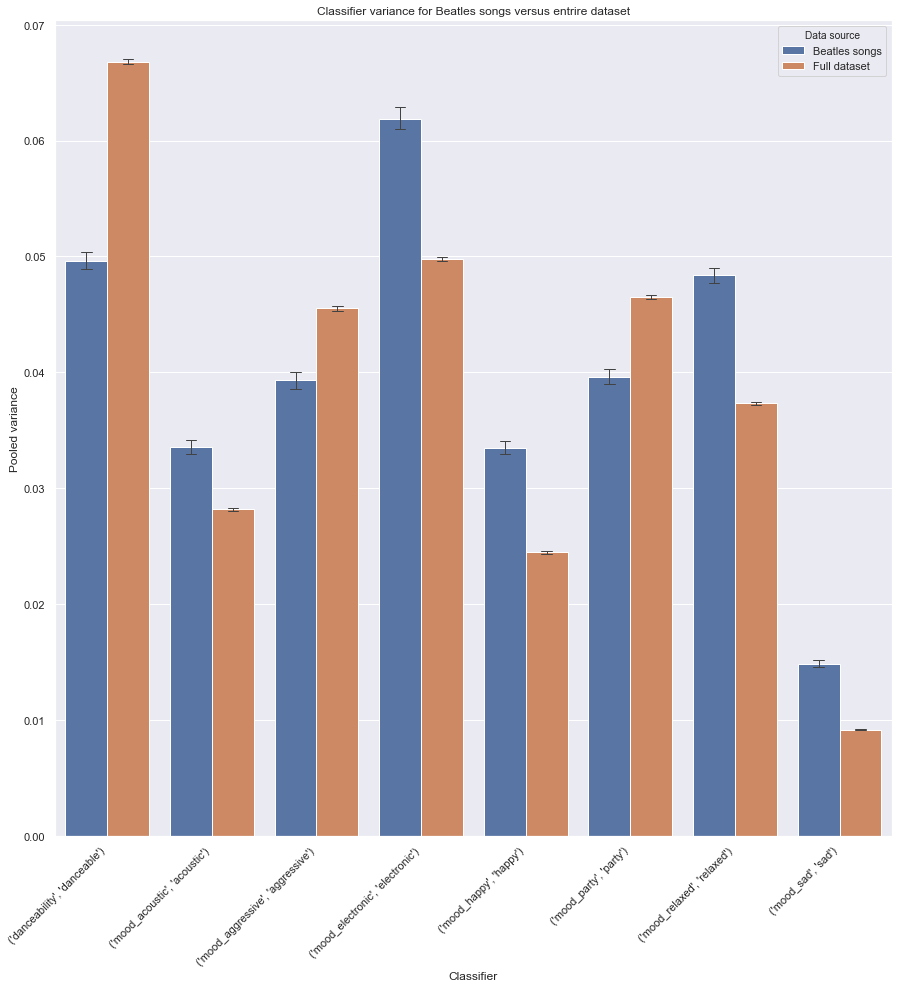

In [3]:
toplot = toplot.melt(id_vars = ['Data source'])
plt.figure()
ax = sns.barplot(data=toplot, x='variable', y='value', hue="Data source", errwidth=1, capsize=.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier variance for Beatles songs versus entrire dataset")
plt.xlabel("Classifier")
plt.ylabel("Pooled variance")
plt.show()

In [34]:
beatles_bitrate = beatles.groupby(['bit_rate']).progress_apply(filter_submissions)
beatles_bitrate_variance = beatles_bitrate[cols].groupby(level=[0,1]).progress_apply(get_variance)

,0
128000,479
192000,396
256000,161
320000,181
448000,4042


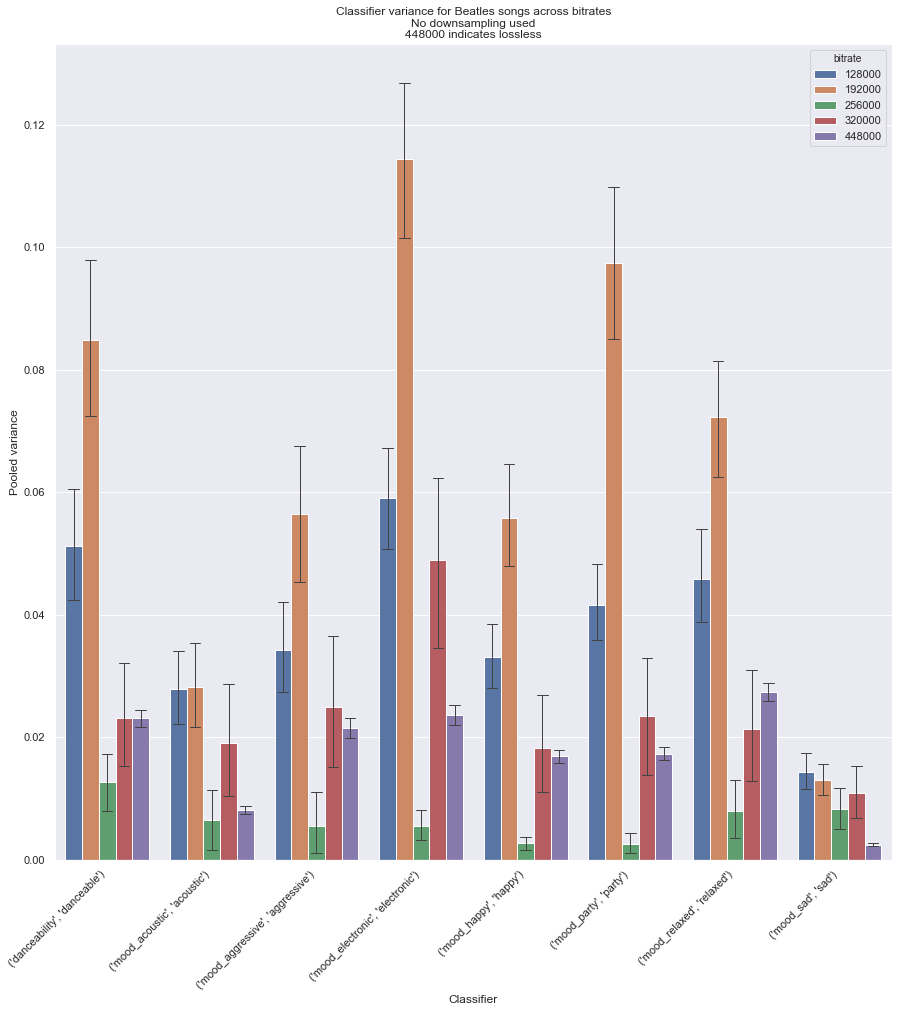

In [52]:
bitrates = [128000, 192000, 256000, 320000, 0]
idx = [128000, 192000, 256000, 320000, 448000]
toplot = pd.DataFrame()
counts = []

for rate in bitrates:
    toadd = beatles_bitrate_variance.loc[rate]
    toadd['bitrate'] = rate
    toplot = toplot.append(toadd)
    counts.append(len(toadd))

counts = pd.DataFrame(counts)
counts.index = idx
display(counts)

toplot['bitrate'] = toplot['bitrate'].replace(to_replace=0, value=448000)
toplot = toplot.melt(id_vars=['bitrate'])


plt.figure()
ax = sns.barplot(data=toplot, x='variable', y='value', hue="bitrate", errwidth=1, capsize=.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier variance for Beatles songs across bitrates\nNo downsampling used\n448000 indicates lossless")
plt.xlabel("Classifier")
plt.ylabel("Pooled variance")
plt.show()